# Introduction

In the mobile gaming industry, A/B testing is a fundamental tool for game developers to understand player behavior, optimize game mechanics, and improve user engagement. By testing different versions of game elements on random subsets of players, developers can gather data-driven insights into how certain changes influence player retention, satisfaction, and monetization. This approach allows teams to make informed decisions that enhance the game experience, balancing user enjoyment with revenue generation.

In the mobile game Cookie Cats, players are engaged in a challenging puzzle game where they progress through levels with occasional "gates" that require waiting or making an in-app purchase to continue. Gates serve as a mechanism to encourage monetization or increase engagement, as players decide whether to invest in progressing more quickly or return to play later. In this particular A/B test, Cookie Cats developers aimed to investigate how the placement of the first gate affects player behavior. Traditionally, the first gate appears at level 30, but in this experiment, it was moved to level 40 for a randomly assigned experimental group.

The test involves 90,189 players, split between a control group (gate at level 30) and an experimental group (gate at level 40). This study will examine how shifting the gate position influences key metrics such as player retention on Day 1 and Day 7, as well as the overall number of game rounds played within the first 14 days. By analyzing these metrics, the development team hopes to determine whether delaying the gate can boost player engagement and increase the likelihood of longer-term retention, ultimately making Cookie Cats a more enjoyable and successful experience.

## Goal of the experiment

To evaluate whether delaying the first gate from level 30 to level 40 increases player engagement and retention in Cookie Cats.

## Target metrics 
This experiment has different metrics to target:
* **Player Engagement:** I'll compare the average number of game rounds (sum_gamerounds) played within the first 14 days after installing the game between each group after finding the first gate.
* **Player Retention:** I'll be comparing the difference in proportions of the Day 1 retention (retention_1) and Day 7 retention (retention_7) between the test and control groups.

## Expected treatment effects

* **Player Engagement:** Given our large customer base, even a modest 3% increase in the mean number of game rounds would be a significant impact and strong evidence of the experiment's effectiveness.
* **Player retention:** We anticipate a subtle but meaningful impact on retention metrics. A 1% increase in day 1 retention and a 0.5% increase in day 7 retention would both be considered significant indicators of success.

# Loading and exploring the data

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy
import duckdb as db
import tea_tasting as tt
import scipy.stats.distributions as dist

In [42]:
data = pd.read_csv('cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


The dataset seems to be cleaned with no missing values.

I'll convert the retention metrics to numbers for better handling:

In [43]:
to_number = ['retention_1', 'retention_7']

for col in to_number:
    data[col] = data[col].astype(int)

In [28]:
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [29]:
data.describe(exclude=[np.number])

,version
count,90189
unique,2
top,gate_40
freq,45489


* The distribution of `sum_gamerounds` is highly skewed, as indicated by the mean (51.87) being slightly higher than the 75th percentile (51) and maximum value (49,854), with a standard deviation of 195.05, suggesting a few users play an exceptionally high number of game rounds. 
* `retention_1` and `retention_7`, with mean values of 0.445 and 0.186 respectively, indicate that roughly 44.5% of users return on day 1, while 18.6% return on day 7.
*  The distribution of the `version` seems to be evenly split, with gate_40 appearing a bit more frequently (45,489 occurrences). 

# Sanity check

`tea_tasting` is a powerful Python library designed specifically for A/B test analysis, offering a range of statistical methods tailored to experiment evaluation. With support for multiple data backends and an extensible API, tea-tasting simplifies the process of analyzing experimental results while ensuring accuracy and computational efficiency. It includes Student's t-test, Z-test, Bootstrap, CUPED for variance reduction, and power analysis and its extensible API allows to customize metrics and statistical tests, adapting the library to the specifics of the experiment needs. It is user-friendly and error-reducing since it reduces the manual work and streamline the analysis.

Let's use this library first to check the sample ratio of the groups, the description in kaggle statest that the sampling was random, so we should expect a ratio of 1 to 1 in each group. The hypothesis we'll be considering here are:

* $H_0: p_{control} = p_{experiment}$ 
* $H_a: p_{control} \neq p_{experiment}$

where p starnds for proportion. Let's verify that:

In [34]:
experiment = tt.Experiment({
    'ratio': tt.SampleRatio(ratio=1)
},
variant='version') # tea_tasting assumes there's a column called variant identifying each group, but it can be modified in the experiment.

experiment.analyze(data)

metric,control,treatment,rel_effect_size,rel_effect_size_ci,pvalue
ratio,44699,45489,-,"[-, -]",0.00861


As we can see, there is a noticeable difference in sample sizes between the control group (gate_30, n=44,699) and the experimental group (gate_40, n=45,489). Under the null hypothesis of an equal 50% chance of being assigned to either group, the probability of observing such a dispersion is quite low, as highlighted by the p-value. This suggests that the group assignments may not have been perfectly balanced, and the observed difference is unlikely due to random chance alone.

In a real scenario would be worth checking with the design team and investigate where the difference could come from. However, despite this discrepancy, we will proceed with the analysis.

# Exploratory Data Analysis (EDA)

## Engagement metric

One of the target metric, `sum_gamerounds`, presents outliers as indicated by its quantiles and maximum value. A histogram visualization would help confirm this and identify potential data quality issues.

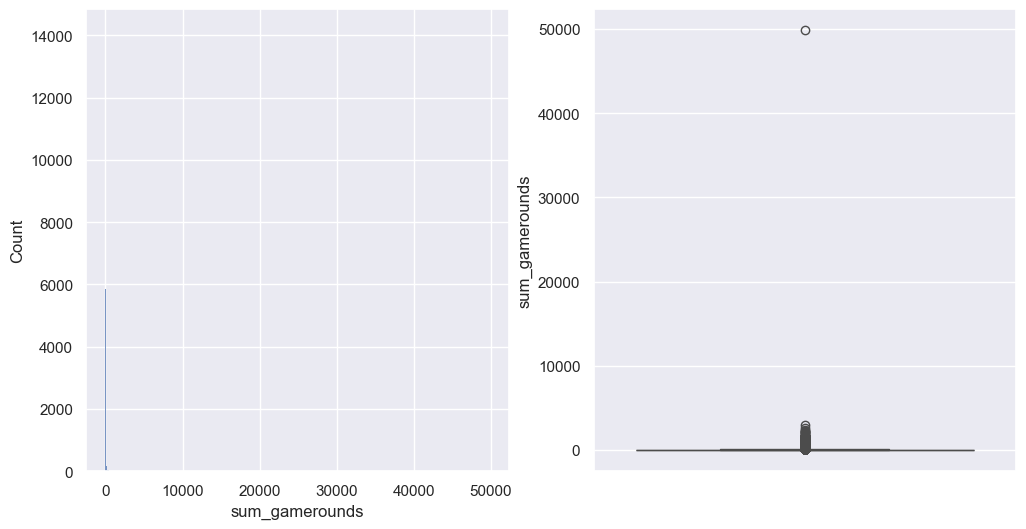

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  
sns.histplot(data['sum_gamerounds'], ax=ax[0])
sns.boxplot(data['sum_gamerounds'], ax=ax[1])
plt.show()

In [31]:
db.query('SELECT * FROM data ORDER BY sum_gamerounds DESC LIMIT 5')

┌─────────┬─────────┬────────────────┬─────────────┬─────────────┐
│ userid  │ version │ sum_gamerounds │ retention_1 │ retention_7 │
│  int64  │ varchar │     int64      │    int64    │    int64    │
├─────────┼─────────┼────────────────┼─────────────┼─────────────┤
│ 6390605 │ gate_30 │          49854 │           0 │           1 │
│  871500 │ gate_30 │           2961 │           1 │           1 │
│ 3271615 │ gate_40 │           2640 │           1 │           0 │
│ 4832608 │ gate_30 │           2438 │           1 │           1 │
│ 5346171 │ gate_40 │           2294 │           1 │           1 │
└─────────┴─────────┴────────────────┴─────────────┴─────────────┘

We have an extreme case where a player seems to have played almost 50.000 game rounds, since the rest of the players do not even reach the figure of 3.000 I'm going to remove this record from the study assuming this is a data quality issue. 

In a real scenario it could be good to confirm with the team if this is an error.

In [44]:
data = data.drop(data[data['sum_gamerounds']>40000].index)

As mentioned in the target metric, I'll be focusing on the average number of game rounds played after finding the first gate in the game, so I'll be removing all records from both groups that haven't played enough rounds to find the first gate. After that, I'll generate a new column counting the number of rounds each player has played after finding the first gate.

In [45]:
idx_to_remove = data[((data['version'] == 'gate_30') & (data['sum_gamerounds'] <= 30)) | 
                     ((data['version'] == 'gate_40') & (data['sum_gamerounds'] <= 40))].index.values.tolist()

print(f"Dataset length before deletion: {len(data)}")
data = data.drop(index=idx_to_remove)
print(f"Dataset length after deletion: {len(data)}")

Dataset length before deletion: 90188
Dataset length after deletion: 29957


We have substantially reduce the number of participants of the experiment but it is still a large enough number to make extract meaningful information.

In [50]:
data['rounds_after_gate'] = np.where(data['version']=='gate_30', data['sum_gamerounds'] - 30, data['sum_gamerounds'] - 40)

In [51]:
data = data.drop(columns=['sum_gamerounds'])

In [52]:
data.to_csv('cookie_cats_clean.csv', index=False)

Let's have a look at the distribution now:

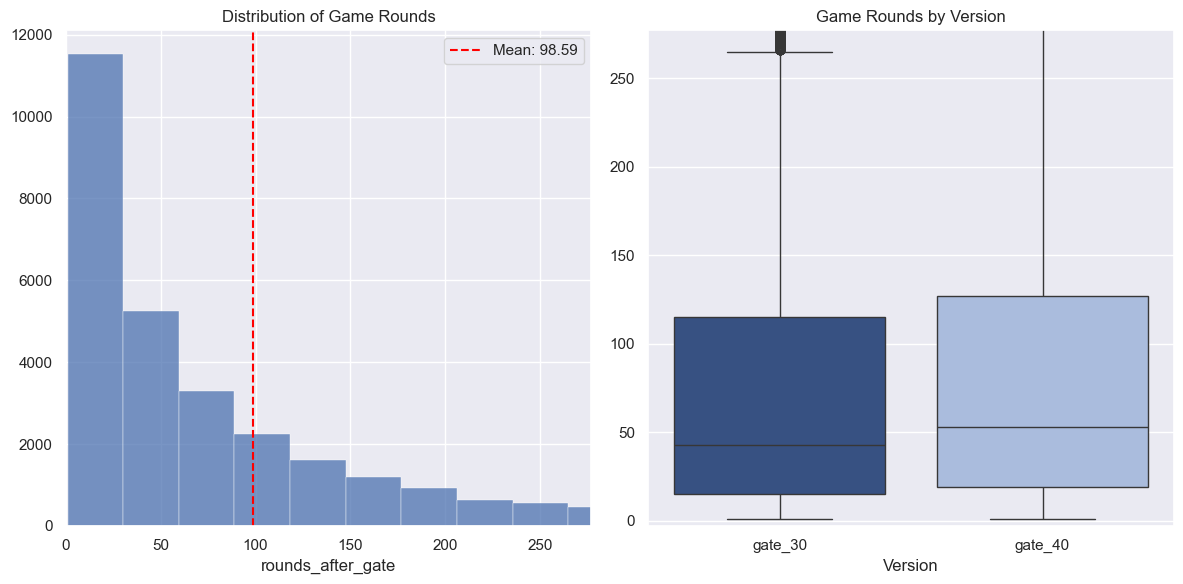

In [54]:
# I'll focus on the bulk, not showing outliers
Q1 = data['rounds_after_gate'].quantile(0.25)
Q3 = data['rounds_after_gate'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

overall_mean = data['rounds_after_gate'].mean()

figure, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data['rounds_after_gate'], bins=100, ax=ax[0])
ax[0].axvline(overall_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {overall_mean:.2f}')
ax[0].set_xlim(0, upper_bound)
ax[0].set_title('Distribution of Game Rounds')
ax[0].set_xlabel('rounds_after_gate')
ax[0].set_ylabel('')
ax[0].legend()

sns.boxplot(x=data['version'], y=data['rounds_after_gate'], hue=data['version'], palette=['#2A4D8F', '#A2B9E5'], ax=ax[1])
ax[1].set_ylim(-3, upper_bound)
ax[1].set_title('Game Rounds by Version')
ax[1].set_xlabel('Version')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [55]:
# I'll divide the data in the two versions and combine the .describe() method for a better comparison
data_gate_30 = data[data['version']=='gate_30']
data_gate_40 = data[data['version']=='gate_40']

describe_gate_30 = data_gate_30['rounds_after_gate'].describe()
describe_gate_40 = data_gate_40['rounds_after_gate'].describe()

describe_comparison = pd.DataFrame({
    'gate_30': describe_gate_30,
    'gate_40': describe_gate_40
})

describe_comparison

,gate_30,gate_40
count,16357.000000,13600.000000
mean,93.770435,104.381471
std,141.679099,151.867245
min,1.000000,1.000000
25%,15.000000,19.000000
50%,43.000000,53.000000
75%,115.000000,127.000000
max,2931.000000,2600.000000


Looking at the charts and the numerical comparison of the two versions from above, it seems that changing the gate from 30 to 40 appears has a positive impact regarding the engagement metric, since the mean, median and the rest of the percentiles present higher values. Besides having less players, the experiment group seems to have greater variability, as shown by the higher standard deviation. 

Now I'll move to the retention metrics to ensure that the higher engagement does not come at the expense of lower retention in the long run.

## Retention metrics

Now let's see the difference on the retention metrics `retention_1` and `retention_7`.

In [56]:
describe_gate_30 = data_gate_30[['retention_1', 'retention_7']].describe()
describe_gate_40 = data_gate_40[['retention_1', 'retention_7']].describe()

describe_gate_30_filtered = describe_gate_30.loc[['count', 'mean', '50%', 'std']]
describe_gate_40_filtered = describe_gate_40.loc[['count', 'mean', '50%', 'std']]

describe_comparison = pd.concat([
    describe_gate_30_filtered[['retention_1']], 
    describe_gate_40_filtered[['retention_1']], 
    describe_gate_30_filtered[['retention_7']], 
    describe_gate_40_filtered[['retention_7']]
], axis=1)

describe_comparison.columns = [
    'gate_30_retention_1', 'gate_40_retention_1',
    'gate_30_retention_7', 'gate_40_retention_7'
]

describe_comparison

,gate_30_retention_1,gate_40_retention_1,gate_30_retention_7,gate_40_retention_7
count,16357.000000,13600.000000,16357.000000,13600.000000
mean,0.804793,0.832279,0.444152,0.490882
50%,1.000000,1.000000,0.000000,0.000000
std,0.396372,0.373632,0.496886,0.499935


Again, it can be seen here that the delay of the first gate in the game seems to point to better results in both metrics. 

# Confidence intervals

I will calculate 95% confidence intervals for the difference of the means of both groups, using both analytical methods and the bootstrapping technique.

## Analytical

For the analytical calculations, I will use the pooled standard deviation. This approach is justified by the assumption of equal variances between the groups and is supported by the large and nearly equal sample sizes on all metrics.

### Engagement metric

In [59]:
mu_30 = np.mean(data_gate_30.rounds_after_gate)
n_30 = data_gate_30.shape[0]
std_30 = np.std(data_gate_30.rounds_after_gate, ddof=1)

mu_40 = np.mean(data_gate_40.rounds_after_gate)
n_40 = data_gate_40.shape[0]
std_40 = np.std(data_gate_40.rounds_after_gate, ddof=1)

z_mult = scipy.stats.norm.ppf(q=0.975)

for mu, n, std, group in zip((mu_30, mu_40), (n_30, n_40), (std_30, std_40), ('gate_30', 'gate_40')):
    lb = mu - z_mult * std / np.sqrt(n)
    ub = mu + z_mult * std / np.sqrt(n)
    print(f"95% CI for the mean of rounds played in version {group} is: ({lb:.2f}, {ub:.2f})")

mu_diff = mu_40 - mu_30

# pooled std
sp = np.sqrt(((n_30 - 1) * std_30**2 + (n_40 - 1) * std_40**2) / (n_30 + n_40 -2))
# pooled standard error
pooled_se = sp * np.sqrt(1/n_30 + 1/n_40)

lb = mu_diff - z_mult * pooled_se
ub = mu_diff + z_mult * pooled_se
print(f"95% CI for the difference of the means among groups is: ({lb:.2f}, {ub:.2f})")

95% CI for the mean of rounds played in version gate_30 is: (91.60, 95.94)
95% CI for the mean of rounds played in version gate_40 is: (101.83, 106.93)
95% CI for the difference of the means among groups is: (7.28, 13.94)


### Retention metrics

In [61]:
for retention in ['retention_1', 'retention_7']:
    print(retention)
    p_30 = np.mean(data_gate_30[retention])
    n_30 = data_gate_30.shape[0]
    se_30 = np.sqrt(p_30 * (1 - p_30) / n_30)
    
    p_40 = np.mean(data_gate_40[retention])
    n_40 = data_gate_40.shape[0]
    se_40 = np.sqrt(p_40 * (1 - p_40) / n_40)
    
    z_mult = scipy.stats.norm.ppf(q=0.975)
    
    for p, n, se, group in zip((p_30, p_40), (n_30, n_40), (se_30, se_40), ('gate_30', 'gate_40')):
        lb = p - z_mult * se
        ub = p + z_mult * se
        print(f"95% CI for the proportion in version {group} is: ({lb:.4f}, {ub:.4f})")
    
    p_diff = p_40 - p_30 
    se = np.sqrt((p_30 * (1 - p_30) / n_30) + (p_40 * (1 - p_40) / n_40))
    
    lb = p_diff - z_mult * se
    ub = p_diff + z_mult * se
    print(f"95% CI for the difference of the proportions among groups is: ({lb:.4f}, {ub:.4f})\n")

retention_1
95% CI for the proportion in version gate_30 is: (0.7987, 0.8109)
95% CI for the proportion in version gate_40 is: (0.8260, 0.8386)
95% CI for the difference of the proportions among groups is: (0.0187, 0.0362)

retention_7
95% CI for the proportion in version gate_30 is: (0.4365, 0.4518)
95% CI for the proportion in version gate_40 is: (0.4825, 0.4993)
95% CI for the difference of the proportions among groups is: (0.0354, 0.0581)



### Results

| Metric                | Gate 30          | Gate 40          | Difference (Gate 40 - Gate 30) |
|-----------------------|------------------|------------------|--------------------------------|
| Rounds Played         | (91.60, 95.94)   | (101.83, 106.93)       | (7.28, 13.94)            |
| Retention (Day 1)     | (0.7987, 0.8109) | (0.8260, 0.8386)       | (0.0187, 0.0362)         |
| Retention (Day 7)     | (0.4365, 0.4518) | (0.4825, 0.4993)       | (0.0354, 0.0581)         |

Based on the results of the confidence intervals:

1. **Engagement (Rounds Played)**:
   - Players in the `gate_40` version play, on average, 10.61 more rounds after passing the first gate compared to the `gate_30` version.
   - This suggests that delaying the gate improves overall player engagement.

2. **Retention (Day 1 and Day 7)**:
   - Day 1 retention is higher for the `gate_40` version (82.93%) compared to the `gate_30` version (80.43%), with a difference of 2.50 percentage points.
   - Day 7 retention also shows a notable increase for `gate_40` (49.02%) compared to `gate_30` (44.35%), with a difference of 4.67 percentage points.

Overall, these results indicate that moving the gate from level 30 to level 40 positively impacts both player engagement and retention. The `gate_40` version is recommended for implementation.

## Bootstrapping

Now I'll move to calculate the same confidence interval empirically.

I'll define a function to help me do this without repeating code:

In [72]:
def bootstrap_ci(
    data_1: pd.DataFrame,
    data_2: pd.DataFrame,
    measure: str,
    label_1: str = 'Gate 30',
    label_2: str = 'Gate 40',
    n_iterations: int = 10000,
    sample_size: int = 1000,
    confidence_level: float = 0.95
) -> None:
    """
    Calculating confidence interval using bootstrapping for the mean, and plotting the KDE with percentile lines.
    """
    
    sample_means_1 = []
    sample_means_2 = []

    for _ in range(n_iterations):
        sample_1 = np.random.choice(data_1[measure], size=sample_size, replace=True)
        sample_2 = np.random.choice(data_2[measure], size=sample_size, replace=True)
        sample_means_1.append(np.mean(sample_1))
        sample_means_2.append(np.mean(sample_2))

    # Calculate percentiles
    lb_1 = np.percentile(sample_means_1, (1 - confidence_level) / 2 * 100)
    ub_1 = np.percentile(sample_means_1, (1 + confidence_level) / 2 * 100)
    lb_2 = np.percentile(sample_means_2, (1 - confidence_level) / 2 * 100)
    ub_2 = np.percentile(sample_means_2, (1 + confidence_level) / 2 * 100)
    
    print(f"95% CI for {measure} in the {label_1} group: ({lb_1:.4f}, {ub_1:.4f})")
    print(f"95% CI for {measure} in the {label_2} group: ({lb_2:.4f}, {ub_2:.4f})")

    # Plot KDE with percentile lines
    plt.figure(figsize=(10, 6))
    sns.kdeplot(sample_means_1, label=label_1, color='blue')
    sns.kdeplot(sample_means_2, label=label_2, color='green')

    # Add vertical lines for confidence intervals
    plt.axvline(lb_1, color='blue', linestyle='--', alpha=0.25)
    plt.axvline(ub_1, color='blue', linestyle='--', alpha=0.25)
    plt.axvline(lb_2, color='green', linestyle='--', alpha=0.25)
    plt.axvline(ub_2, color='green', linestyle='--', alpha=0.25)

    plt.xlabel(f"Sample Mean of {measure}")
    plt.ylabel("Density")
    plt.title(f"Bootstrap Sample Mean Distribution for {measure}")
    plt.legend()
    plt.show()

    return

### Engagement metric

95% CI for rounds_after_gate in the Gate 30 group: (85.0618, 102.9330)
95% CI for rounds_after_gate in the Gate 40 group: (95.1820, 113.9131)


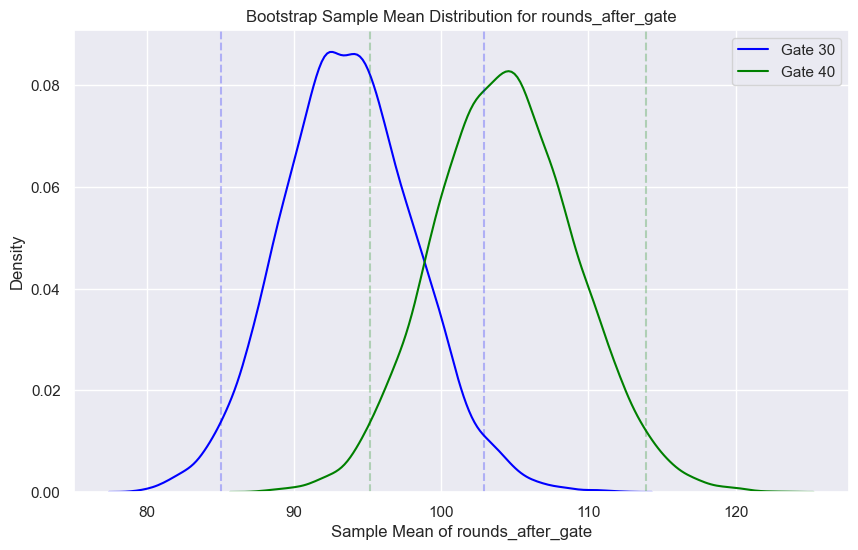

In [73]:
bootstrap_ci(data_gate_30, data_gate_40, 'rounds_after_gate')

### Retention metrics

95% CI for retention_1 in the Gate 30 group: (0.7800, 0.8290)
95% CI for retention_1 in the Gate 40 group: (0.8090, 0.8550)


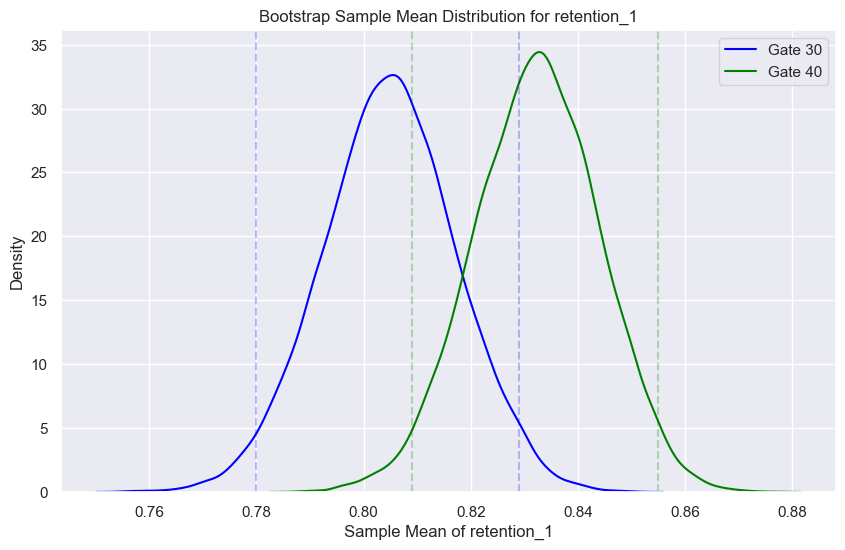

In [74]:
bootstrap_ci(data_gate_30, data_gate_40, 'retention_1')

95% CI for retention_7 in the Gate 30 group: (0.4130, 0.4750)
95% CI for retention_7 in the Gate 40 group: (0.4600, 0.5210)


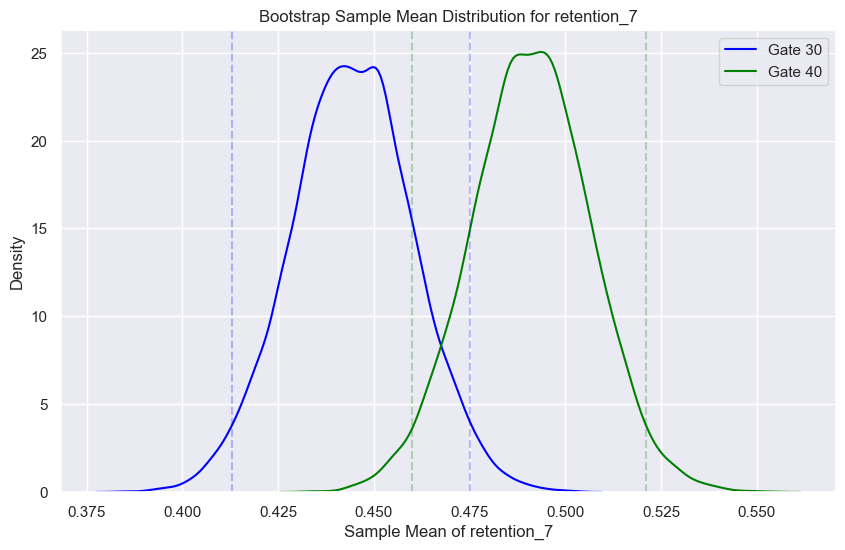

In [75]:
bootstrap_ci(data_gate_30, data_gate_40, 'retention_7')

## Conclusions

| Metric                | Gate 30 (95% CI)        | Gate 40 (95% CI)         | 
|-----------------------|-------------------------|--------------------------|
| Rounds Played         | (85.06, 102.93)         | (95.18, 113.91)          | 
| Retention (Day 1)     | (0.7800, 0.8290)        | (0.8090, 0.8550)         | 
| Retention (Day 7)     | (0.4130, 0.4750)        | (0.4600, 0.5210)         | 

Using bootstrapping we see that the Confidence Interval overlap in all the distributions, but it is still clear that the experiment has a distribution with higher values.

# A/B Testing with tea_tasting

The hypothesis we'll be handling here are:
* $H_0: \mu_{30} = \mu_{40} $ The mean or proportion of the gate at level 30 is equal to the gate 40.
* $H_1: \mu_{30} \neq \mu_{40} $ The mean or proportion of the two groups are different.

In [76]:
experiment = tt.Experiment({
    'gamerounds_per_user': tt.Mean('rounds_after_gate'),
    'day1_retention': tt.Mean('retention_1'),
    'day7_retention': tt.Mean('retention_7')
},
variant='version')

result = experiment.analyze(data)

result

metric,control,treatment,rel_effect_size,rel_effect_size_ci,pvalue
gamerounds_per_user,93.8,104,11%,"[7.6%, 15%]",5.50e-10
day1_retention,0.805,0.832,3.4%,"[2.3%, 4.5%]",7.08e-10
day7_retention,0.444,0.491,11%,"[7.9%, 13%]",6.89e-16


I will manually compare the result from the table above with the tests:

In [84]:
for measure in ['rounds_after_gate','retention_1', 'retention_7']:
    dx = data.groupby('version')[measure].agg([lambda x: np.mean(x), lambda x: np.std(x, ddof=1), 'size'])
    dx.columns = ['mu', 'sd', 'N']
    
    if measure == 'rounds_after_gate':
        # unpooled standard deviation (standard deviations are similar but sample sizes are not)
        se = np.sqrt(dx.sd.gate_30**2/dx.N.gate_30 + dx.sd.gate_40**2/dx.N.gate_40)
    
    else:
        p_comb = data[measure].mean()
        va = p_comb * (1 - p_comb)
        se = np.sqrt(va * (1/dx.N.gate_30 + 1/dx.N.gate_40))

    t_stat = (dx.mu.gate_30 - dx.mu.gate_40)/se
    p_value = 2 * dist.norm.cdf(-np.abs(t_stat))
    print(f"{measure} t_statistic: {t_stat:.2e}, p-value:{ p_value:.2e}")

rounds_after_gate t_statistic: -6.21e+00, p-value:5.42e-10
retention_1 t_statistic: -6.13e+00, p-value:8.83e-10
retention_7 t_statistic: -8.07e+00, p-value:6.85e-16


# Final Recommendation
Based on these results, the treatment (moving the gate to level 40) has proven to be highly effective, achieving and significantly exceeding the expected treatment effects for player engagement and retention. Specifically:

- Player Engagement: The 11% increase in game rounds per user demonstrates that players are more engaged with the game due to the new gate position.
- Player Retention: Both short-term (Day 1) and long-term (Day 7) retention show substantial improvements, indicating the treatment enhances the overall player experience and encourages sustained play.

The new gate position at level 40 should be implemented across the entire player base, as the experiment clearly demonstrates its effectiveness in boosting player engagement and retention. Post-implementation, the company should monitor engagement and retention metrics to ensure the positive impact is sustained and to identify any long-term trends. Additionally, this successful experiment highlights the value of data-driven decision-making in game design, paving the way for future experiments to optimize player experience and further enhance key metrics.